## Homework 3: Classification

1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe

2) Convert default and student to categorical variables.

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC.

In [18]:
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import re

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import pylab as plt
%pylab inline
import seaborn
import numpy.random as nprnd
import random
import json

pd.set_option('display.max_columns', 500)
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [4]:
df_default = pd.get_dummies(df['default'])
df_student = pd.get_dummies(df['student'])
df_final = pd.concat([df[['balance', 'income']],df_default, df_student],axis=1)
df_final.head()

,balance,income,No,Yes,No,Yes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


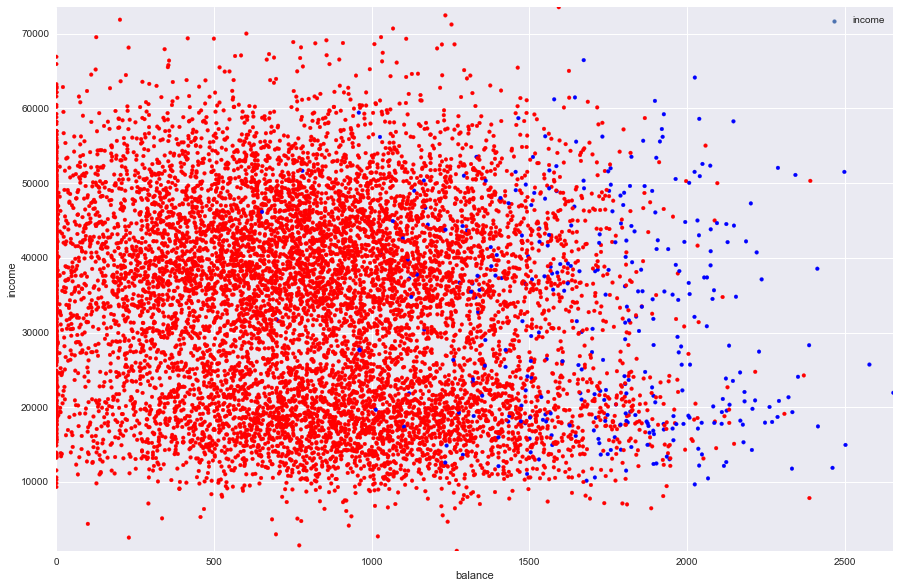

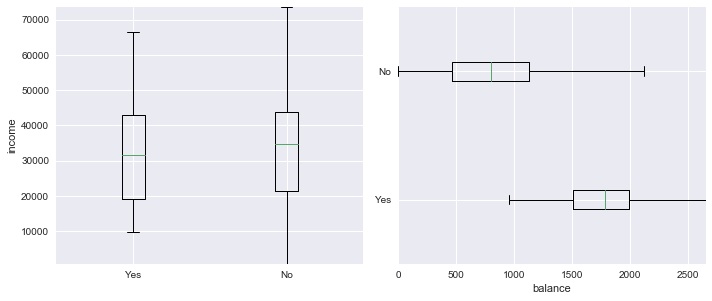

In [46]:
# setup figure
plt.figure(figsize=(15, 10))

# scatter plot of balance (x) and income (y)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(df.balance, df.income, s = 14, c=(df.default == 'Yes'), cmap=cm_bright)        
plt.xlim((df.balance.min(), df.balance.max()))
plt.ylim((df.income.min(), df.income.max()))
plt.xlabel('balance')
plt.ylabel('income')
plt.legend(loc='upper right')

# box plots for income
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(221)
ax1.boxplot([df.income[df.default == 'Yes'], df.income[df.default == 'No']])
ax1.set_ylim((df.income.min(), df.income.max()))
ax1.set_xticklabels(('Yes', 'No'))
ax1.set_ylabel('income')

# box plots for balance
ax2 = plt.subplot(222)
ax2.boxplot([df.balance[df.default == 'Yes'], df.balance[df.default == 'No']], vert=0)
ax2.set_xlim((df.balance.min(), df.balance.max()))
ax2.set_yticklabels(('Yes', 'No'))
ax2.set_xlabel('balance')
plt.tight_layout()
